In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janata-hack-machine-learning-for-banking/test_fjtUOL8.csv
/kaggle/input/janata-hack-machine-learning-for-banking/train_fNxu4vz.csv
/kaggle/input/janata-hack-machine-learning-for-banking/sample_submission_HSqiq1Q.csv


In [17]:
#loading libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
Dataset_train=pd.read_csv('../input/janata-hack-machine-learning-for-banking/train_fNxu4vz.csv')
Dataset=pd.read_csv('../input/janata-hack-machine-learning-for-banking/test_fjtUOL8.csv')

Dataset=pd.concat([Dataset_train, Dataset], axis=0, ignore_index=True, sort=False)

In [4]:
Dataset_train

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3


#  Data preprocessing
*  converting into appropriate data types
*  Log transformation wherever found neccessary
*  Fill nans with mean (numeric)
*  Fill nans with mode (category) or you can use 'Unknown' label as well
*  Label encoding / one hot encoding for category columns

In [6]:
## all combined into one cell but one should go column by column to see how 
Dataset['Loan_Amount_Requested']= Dataset['Loan_Amount_Requested'].str.replace("," ,'')

Dataset['Loan_Amount_Requested']=Dataset['Loan_Amount_Requested'].astype(int)

Dataset['Loan_Amount_Requested'].describe()

Dataset['Loan_Amount_Requested']=np.log(Dataset['Loan_Amount_Requested'])

Dataset['Months_Since_Deliquency'].describe()

Dataset['Months_Since_Deliquency']=np.log(Dataset['Months_Since_Deliquency'], where = Dataset['Months_Since_Deliquency']!=0)

Dataset['Annual_Income'].describe()

Dataset['Annual_Income']=np.log(Dataset['Annual_Income'])

Dataset['Number_Open_Accounts'].describe()

Dataset['Number_Open_Accounts']=np.log(Dataset['Number_Open_Accounts'], where = Dataset['Number_Open_Accounts']!=0)


Dataset['Total_Accounts']=np.log(Dataset['Total_Accounts'])

Dataset['Home_Owner'].fillna('unknown', inplace=True)

Dataset['Length_Employed']=Dataset['Length_Employed'].str.replace('years', '')

Dataset['Length_Employed']=Dataset['Length_Employed'].replace('1 year', 1)

Dataset['Length_Employed']=Dataset['Length_Employed'].replace('10+ ', 11)

Dataset['Length_Employed']=Dataset['Length_Employed'].replace('< 1 year', 0)

Dataset['Length_Employed'].fillna(21, inplace=True)

Dataset['Length_Employed']=Dataset['Length_Employed'].astype(int)

label_encode=LabelEncoder()

Dataset['Gender']=label_encode.fit_transform(Dataset['Gender'])

Dataset['Purpose_Of_Loan'].value_counts()

Dataset['Purpose_Of_Loan']=Dataset['Purpose_Of_Loan'].map({'debt_consolidation':1, 'credit_card':2,
                                                           'home_improvement':3, 'other':4,
                                                           'major_purchase':5, 'small_business':6,
                                                           'car':7, 'medical':8, 
                                                           'moving':9, 'vacation':10,
                                                           'wedding':11, 'house':12,
                                                           'renewable_energy':13, 'educational':14})

In [7]:
Dataset=pd.get_dummies(Dataset, columns=['Home_Owner', 'Income_Verified'], drop_first=True)

In [10]:
Dataset.isnull().sum()
Dataset.shape

(273850, 19)

# Creating X and Y 

*  We have different datasets for different features combo . We chose Dataset_try1 because it gave the best f1 score  

 Lets try adding features to dataset .Following are the features that we have tried.

* Open account ratio
*  Closed account ratio 


In [11]:
Dataset['Account_ratio']=Dataset['Number_Open_Accounts']/Dataset['Total_Accounts']
Dataset.head(5)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Annual_Income,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Home_Owner_unknown,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Account_ratio
0,10000001,8.853665,0,11.127263,7,18.37,0,NaN,2.197225,2.639057,0,1.0,0,0,0,1,0,0,1,0.832579
1,10000002,10.308953,4,NaN,1,14.93,0,2.833213,2.484907,3.178054,0,3.0,0,0,0,0,0,0,0,0.781896
2,10000003,10.115570,7,11.232767,1,15.88,0,NaN,2.484907,2.772589,1,3.0,0,0,0,0,0,1,0,0.896241
3,10000004,9.680344,0,10.935960,1,14.34,3,NaN,2.772589,3.091042,1,3.0,0,0,0,0,1,1,0,0.896975
4,10000005,9.740969,8,11.472103,1,22.17,1,NaN,2.944439,3.401197,0,1.0,0,0,1,0,0,1,0,0.865707


In [12]:
# addition of feature closed account ratio
## closed account ratio
Dataset_try1 = Dataset.copy()
Dataset_try1['closed_account_ratio'] = 1 - Dataset_try1['Account_ratio']
Dataset_try1.head(5)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Annual_Income,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,...,Interest_Rate,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Home_Owner_unknown,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Account_ratio,closed_account_ratio
0,10000001,8.853665,0,11.127263,7,18.37,0,NaN,2.197225,2.639057,...,1.0,0,0,0,1,0,0,1,0.832579,0.167421
1,10000002,10.308953,4,NaN,1,14.93,0,2.833213,2.484907,3.178054,...,3.0,0,0,0,0,0,0,0,0.781896,0.218104
2,10000003,10.115570,7,11.232767,1,15.88,0,NaN,2.484907,2.772589,...,3.0,0,0,0,0,0,1,0,0.896241,0.103759
3,10000004,9.680344,0,10.935960,1,14.34,3,NaN,2.772589,3.091042,...,3.0,0,0,0,0,1,1,0,0.896975,0.103025
4,10000005,9.740969,8,11.472103,1,22.17,1,NaN,2.944439,3.401197,...,1.0,0,0,1,0,0,1,0,0.865707,0.134293


In [13]:
# Using Dataset_try1 with one more feature
Dataset_test=Dataset_try1[Dataset_try1['Interest_Rate'].isnull()==True]
Dataset=Dataset_try1[Dataset_try1['Interest_Rate'].isnull()!=True]

In [ ]:
# Dataset_test=Dataset[Dataset['Interest_Rate'].isnull()==True]
# Dataset=Dataset[Dataset['Interest_Rate'].isnull()!=True]

In [14]:
X=Dataset.drop(['Interest_Rate', 'Loan_ID'], axis=1)
Y=Dataset['Interest_Rate']


X=X.iloc[:, :].values
Y=Y.iloc[:].values

imputer=SimpleImputer(missing_values=np.nan, strategy='mean')

X[:, 2:3]=imputer.fit_transform(X[:, 2:3])

X[:, 6:7]=imputer.fit_transform(X[:, 6:7])


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=0)

In [21]:
#randomforest classifier
rc=RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, n_jobs=-1, random_state=100)
rc.fit(X,Y)
Y_predict=rc.predict(X_test)

print(f1_score(Y_test,Y_predict, average='weighted'))


0.527001020116565


In [23]:
#LGBMClassifier
lg=LGBMClassifier(boosting_type='gbdt', max_depth=14, learning_rate=0.14, objective='multiclass', reg_alpha=0,
                   reg_lambda=1, n_jobs=-1, random_state=100, n_estimators=600)

lg.fit(X_train,Y_train)
Y_predict=lg.predict(X_test)

print(f1_score(Y_test,Y_predict, average='weighted'))



0.5393005401804208


In [24]:
X_main_test=Dataset_test.drop(['Interest_Rate', 'Loan_ID'], axis=1)

X_main_test=X_main_test.iloc[:, :].values

X_main_test[:, 2:3]=imputer.fit_transform(X_main_test[:, 2:3])

X_main_test[:, 6:7]=imputer.fit_transform(X_main_test[:, 6:7])

pd.DataFrame(X_main_test).isnull().sum()


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

In [33]:
Y_test_predict=lg.predict(X_main_test)

sample_submission=pd.read_csv('../input/janata-hack-machine-learning-for-banking/sample_submission_HSqiq1Q.csv')
sample_submission['Interest_Rate']=Y_test_predict

sample_submission.to_csv('only_lgbm.csv', index=False)  

# Cross validation and base score comparisons
* 10 kfold with shuffle 
* each fold creates a prediction which is stored in results[]
* the results are converted into a dataframe which is used get our final prediction

In [26]:
X=pd.DataFrame(X)
Y=pd.DataFrame(Y)
X_main_test=pd.DataFrame(X_main_test)

kf=KFold(n_splits=10, random_state=100, shuffle=True)

y_test_predict=0
f1_score1 = 0
j=1
result={}
for i, (train_index, test_index) in enumerate(kf.split(Dataset)):
    
   Y_train, Y_valid = Y.iloc[train_index], Y.iloc[test_index]
   X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
   
   print( "\nFold ", j)
    
   model=lg.fit(X_train,Y_train)
   pred = model.predict(X_valid)
   
   print(f1_score(Y_valid,pred, average='weighted'))
   f1_score1+=f1_score(Y_valid,pred, average='weighted')
    
   y_test_predict+=model.predict(X_main_test)  
   result[j]=model.predict(X_main_test)
   j+=1
   
    
results=y_test_predict/10   
results=np.round(results, decimals=0)
print(f1_score1/10)

d = pd.DataFrame()
for i in range(1, 11):
    d = pd.concat([d,pd.DataFrame(result[i])],axis=1)
d.columns=['1','2','3','4','5','6','7','8','9','10']




Fold  1


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5304216741210254

Fold  2
0.531655500605383

Fold  3
0.536413350122969

Fold  4
0.5404335947392582

Fold  5
0.5360273595521782

Fold  6
0.5383911660107997

Fold  7
0.5311902481251548

Fold  8
0.5306327030861933

Fold  9
0.5397697189931273

Fold  10
0.5224263766786057
0.5337361692034694


# Submission strategy
* Take mode from all the folds used for prediction

In [35]:
re = d.mode(axis=1)[0]
sample_submission=pd.read_csv('../input/janata-hack-machine-learning-for-banking/sample_submission_HSqiq1Q.csv')
sample_submission['Interest_Rate']=re

sample_submission.to_csv('kfold_lgbm with mode value.csv', index=False)

Execute till above to get the final score

# Feature importances

Plotting feature importances plot . This is the plot that was used to create extra features.

In [29]:
lg.feature_importances_

array([8614, 3155, 7464, 2693, 8323, 1845, 4451, 2784, 4719,  590,    0,
         23,  271,  633,  372,  617,  644, 4938, 1864], dtype=int32)

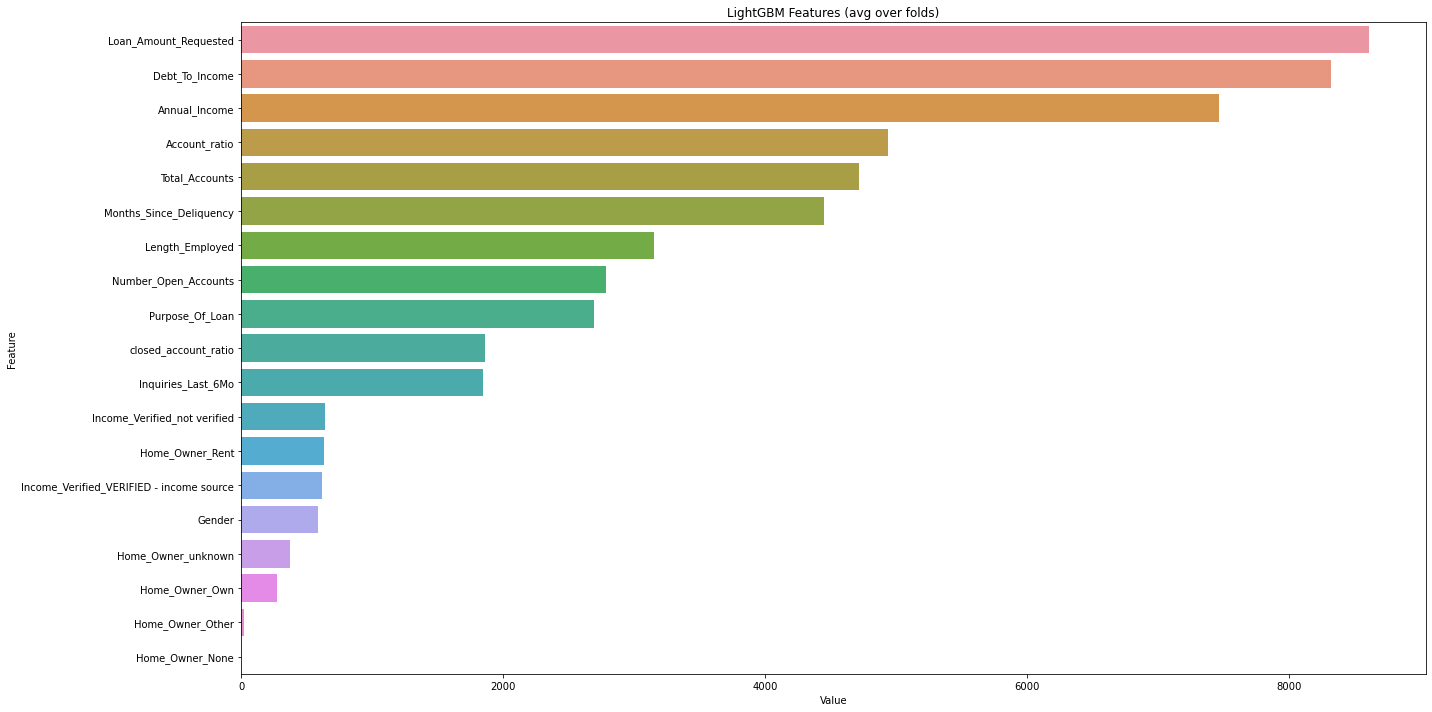

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
Dataset_plot = Dataset.drop(['Loan_ID','Interest_Rate'],axis = 1)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lg.feature_importances_,Dataset_plot.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')